# Regrid bottom roughness topog and save water column depth as a topog file.

In [1]:
#import cosima_cookbook as cc
#from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38099/status,
Dashboard: /proxy/38099/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43669,Workers: 0
Dashboard: /proxy/38099/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39747,Total threads: 4
Dashboard: /proxy/44173/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:36611,


In [3]:
tidal_roughness = xr.open_dataset('/g/data/tm70/cy8964/mom6/input/input-8km/bottom_roughness_Charrassin_nocavity_cropped.nc')


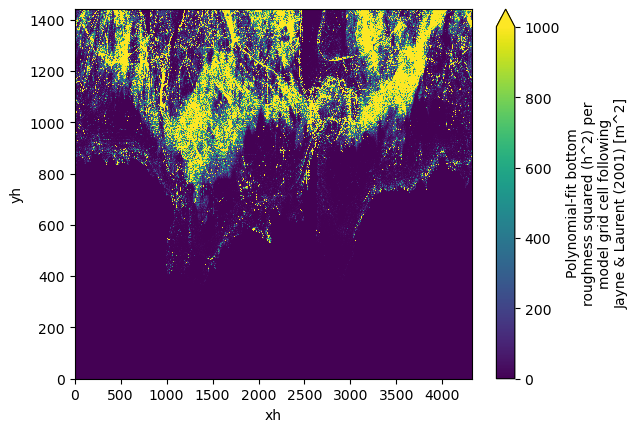

In [4]:
tidal_roughness.h2.plot(vmax = 1000)

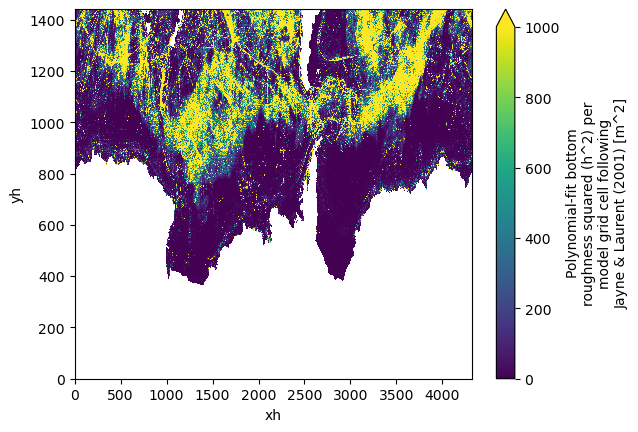

In [5]:
tidal_roughness.h2.where(tidal_roughness.h2>0).plot(vmax = 1000)

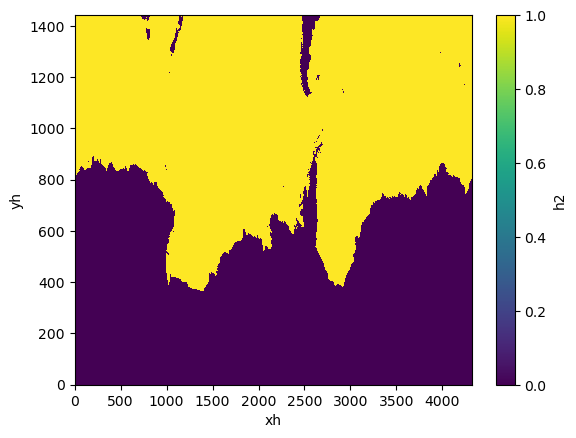

In [6]:
tidal_roughness_smooth_mask = (tidal_roughness.h2.where(tidal_roughness.h2>0)*0+1).fillna(0)
tidal_roughness_smooth_mask.plot()

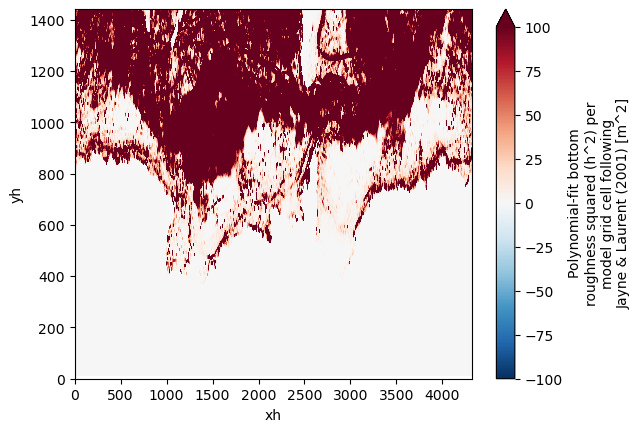

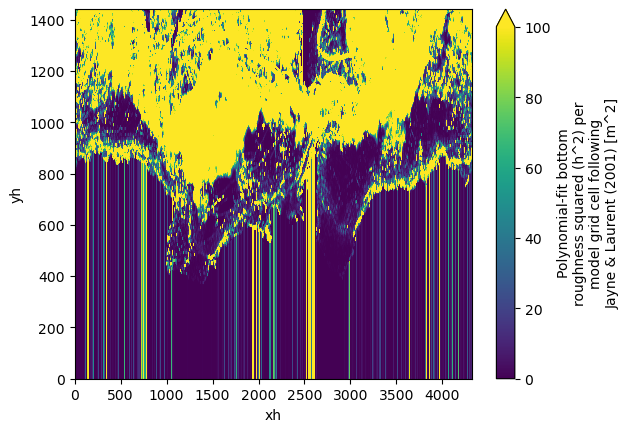

In [17]:
smoothed_tidal_roughness = tidal_roughness.h2.rolling(yh = 12).mean()
smoothed_tidal_roughness.plot(vmax = 100)
plt.show()
smoothed_tidal_roughness = smoothed_tidal_roughness.where(smoothed_tidal_roughness>0).bfill('yh').bfill('xh')
smoothed_tidal_roughness.plot(vmax = 100)
plt.show()


In [18]:
extended_tidal_roughness = tidal_roughness.copy()
extended_tidal_roughness['h2'] = tidal_roughness.h2.where(tidal_roughness.h2>0).fillna(0) + \
                        smoothed_tidal_roughness.where(tidal_roughness.h2==0).where(tidal_roughness.yh<1100).fillna(0)


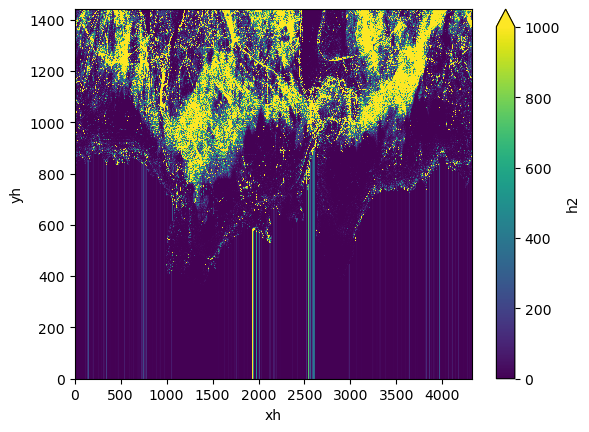

In [19]:
extended_tidal_roughness.h2.plot(vmax = 1000)

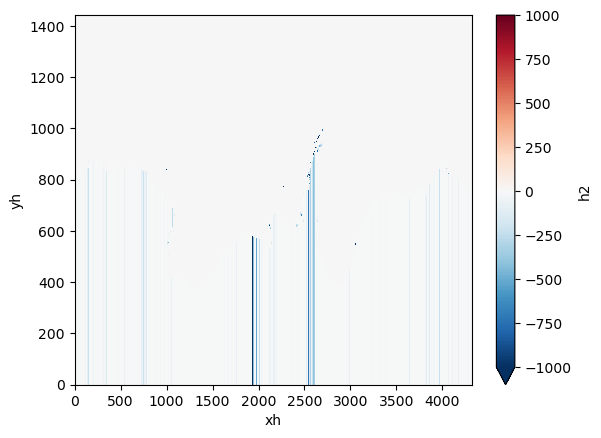

In [20]:
(tidal_roughness.h2 - extended_tidal_roughness.h2).plot(vmax = 1000, vmin = -1000, cmap = 'RdBu_r')

In [22]:
extended_tidal_roughness.h2.attrs = {'description':'extended into cavities with smoothed over 1 degree - see https://github.com/claireyung/mom6-panAn-iceshelf-tools/generate-draft/tidal_roughness_extrap.ipynb'}
extended_tidal_roughness

<xarray.Dataset> Size: 125MB
Dimensions:  (yh: 1442, xh: 4320)
Dimensions without coordinates: yh, xh
Data variables:
    h2       (yh, xh) float32 25MB 9.352 12.45 34.33 ... 599.1 571.4 1.437e+04
    lon      (yh, xh) float64 50MB ...
    lat      (yh, xh) float64 50MB ...
Attributes:
    history:    Created by cy8964 (Claire Yung) on 2025-06-13, using https://...
    inputFile:  /g/data/ik11/inputs/SYNBATH/SYNBATH.nc (md5 hash: ccad533f2e7...

In [23]:
extended_tidal_roughness.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/bottom_roughness_extended_into_cavity.nc')

# Save h as topog

In [3]:
topog = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/150925/topog_Charrassin_open_cavity_noGL5m_new150925.nc')
h = xr.open_dataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-nancheck3-150925files-v2/output004/access-om3.mom6.3d.h.1day.mean.1900.nc')


In [6]:
topog

<xarray.Dataset> Size: 75MB
Dimensions:  (ny: 1442, nx: 4320)
Dimensions without coordinates: ny, nx
Data variables:
    depth    (ny, nx) float32 25MB ...
    lat      (ny, nx) float32 25MB ...
    lon      (ny, nx) float32 25MB ...
Attributes:
    description:  Charrassin 2025 depth regridded onto global 1/12th (8km) gr...

In [8]:
h.h.isel(time = 0).sum('zl')#.plot()

<xarray.DataArray 'h' (yh: 1442, xh: 4320)> Size: 25MB
array([[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [3469.724 , 3518.6934, 3507.117 , ..., 2564.2407, 2931.7285,
        3247.8174],
       [3558.7004, 3484.7097, 3448.6648, ..., 2560.2412, 2836.442 ,
        3214.1963],
       [3376.4255, 3629.2393, 3591.793 , ..., 2515.2798, 2729.7737,
        2744.3623]], dtype=float32)
Coordinates:
  * xh       (xh) float64 35kB -280.0 -279.9 -279.8 -279.7 ... 79.79 79.88 79.96
  * yh       (yh) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
    time     object 8B 1900-02-01 12:00:00

In [10]:
topog_ocean_thick = topog.copy()
topog_ocean_thick['depth'] = topog_ocean_thick.depth*0+h.h.isel(time = 0).sum('zl').drop('time').values
topog_ocean_thick['depth']=topog_ocean_thick.depth.where(topog_ocean_thick.depth>1e-9).fillna(0)
topog_ocean_thick.depth.attrs = {'description':
                                 'Charrassin 2025 depth regridded onto global 1/12th (8km) grid, filled elsewhere with GEBCO 2024 data. Generated with notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/add_charrassin_bathy/generate-draft/Generate-Charrassin-bathy.ipynb. Then processed to remove grounded ice and enforce a minimum ocean thickness of 5m according to initial conditions in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/generate-draft/process-topo-8k-minimal-topoedited.ipynb. No water column min/max applied, no topo edits and no isolated seas removal. OCEAN THICKNESS FROM MODEL RUN SEE - see https://github.com/claireyung/mom6-panAn-iceshelf-tools/generate-draft/tidal_roughness_extrap.ipynb'
                                }
topog_ocean_thick



<xarray.Dataset> Size: 75MB
Dimensions:  (ny: 1442, nx: 4320)
Dimensions without coordinates: ny, nx
Data variables:
    depth    (ny, nx) float32 25MB 0.0 0.0 0.0 ... 2.515e+03 2.73e+03 2.744e+03
    lat      (ny, nx) float32 25MB ...
    lon      (ny, nx) float32 25MB ...
Attributes:
    description:  Charrassin 2025 depth regridded onto global 1/12th (8km) gr...

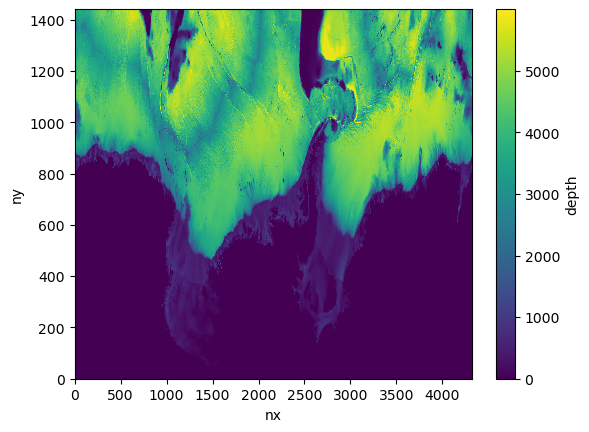

In [11]:
topog_ocean_thick.depth.plot()

In [12]:
topog_ocean_thick.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/150925/ocean_thickness_topog_Charrassin_open_cavity_noGL5m_new150925.nc')

Tidal file - use https://github.com/ACCESS-NRI/om3-scripts/blob/main/external_tidal_generation/generate_tide_amplitude.py

```
qsub -I -P x77 -q normalbw -l ncpus=28,mem=120G,walltime=05:00:00,storage=gdata/hh5+gdata/ik11+gdata/x77+scratch/x77+gdata/xp65
module use /g/data/xp65/public/modules
module load conda/analysis3

cd /home/156/cy8964/model-tools/om3-scripts/external_tidal_generation

python3 generate_tide_amplitude.py --hgrid-file=/g/data/x77/cy8964/mom6/input/input-8km/ocean_hgrid_cropped.nc --topog-file=/g/data/x77/cy8964/mom6/input/input-8km/150925/ocean_thickness_topog_Charrassin_open_cavity_noGL5m_new150925.nc --method=conservative_normed --data-path=/g/data/ik11/inputs/TPXO10_atlas_v2 --output=/g/data/x77/cy8964/mom6/input/input-8km/tideamp_Charrassin_cavity_cropped.nc
